Wykresy:

1) Dystrybucja - violin, boxplot, densityplot, histogram

2) Rozkłąd kilku zmiennych - scatter, bubble-scatter, heatmap, correlogram, densityplot

3) Rankingi - barplot, lolipop plot, spider, parallellines, circular barplot

4) Część całości - stacked barplot, donut plot, pie chart, treemap, dendrogram, venn diagram, sunburst

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib.gridspec as gridspec
import matplotlib.patches as patch
import seaborn as sns
import numpy as np
import math
import matplotlib
import re
from matplotlib.patches import Patch
import bokeh
from matplotlib_venn import venn3
import squarify

In [62]:
#usuwam wiodącą spację z datasetu - śmieć, który się ostał po webscrappingu; zmieniam błędną nazwę ostatniej kolumny
df=pd.read_csv('https://raw.githubusercontent.com/JonothorDarry/Wizualizacje_Python/master/H3Units.csv')
df.replace(to_replace =' ', value='', regex=True, inplace=True)
print(df.at[2,'Unit_name'])
df['Special_abilities']=df['Special Ablility']
del df['Special Ablility']
df.loc[df['Special_abilities'].isna(),'Special_abilities']='-'

#Tworzę nową własność ze 'Special_abilities' - typ jednostki
df['Type']='Warrior'
#Devil i archdevil mają własność 'Teleporting' - de facto tożsama z flying
k=df['Special_abilities'].str.contains('Flying|Teleporting')
l=df['Special_abilities'].str.contains('Ranged')
df.loc[k,'Type']='Flying'
df.loc[l,'Type']='Ranged'

Archer


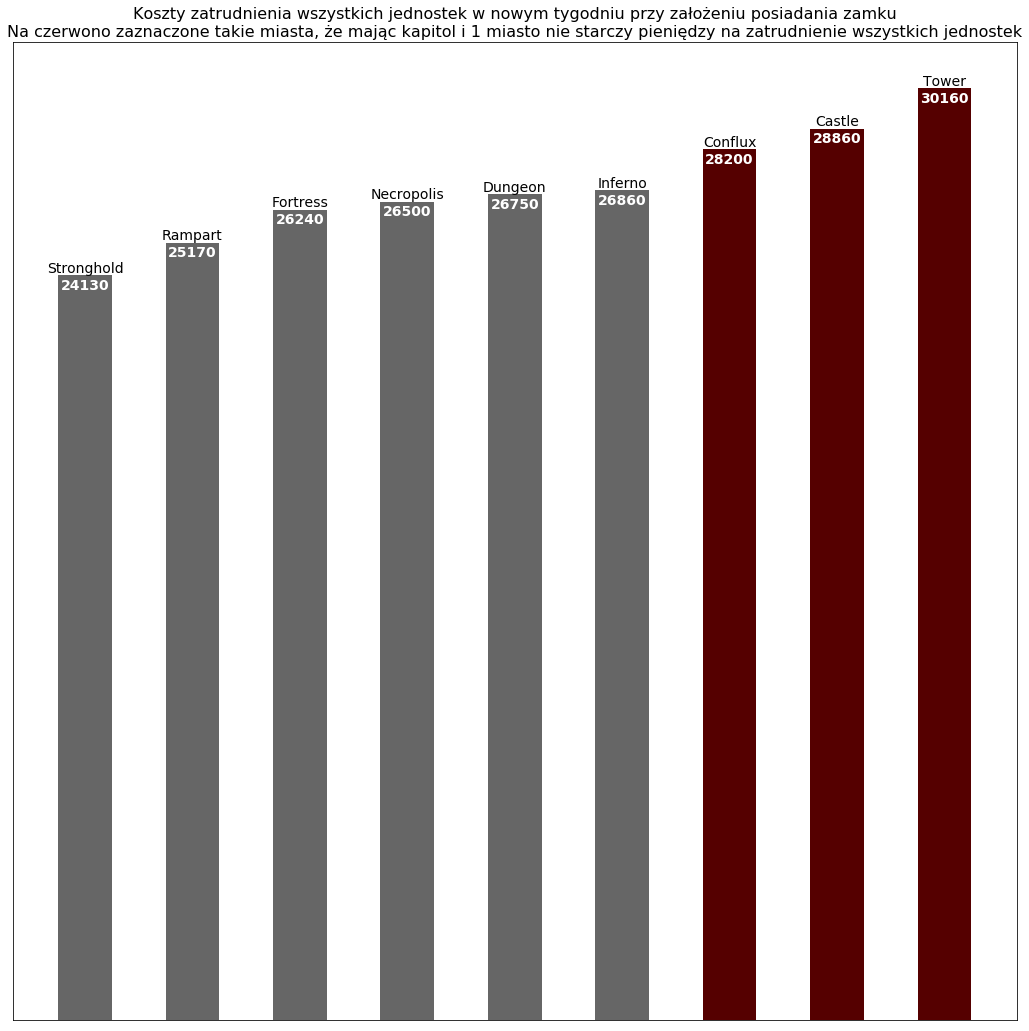

In [63]:
#ranking #1 - Barplot - zsumowane koszty zatrudnienia wszystkich jednostek w nowym tygodniu - założenie posiadania Zamku
df2=df.copy()
df2['All']=df2['Growth']*df2['Gold']*2
k=df2['Level'].str.contains('\+')
df2=df2[k]
df2=df2.groupby(['Castle'], as_index=False).sum().sort_values(by='All')

fig, ax=plt.subplots(1,1)
fig.set_size_inches(18,18)

cncs=df2.columns.get_loc('Castle')
cnal=df2.columns.get_loc('All')
for i in range(0, df2.shape[0], 1):
    Z=df2.iat[i, cnal]
    #Rysowanie bara w określonym punkcie; kolor w zależności od tego, czy wartość w ost. kolumnie przekracza 7*4000
    if (Z<28000):
        ax.bar(x=i, height=Z, color='#666666', width=0.5)
    else:
        ax.bar(x=i, height=Z, color='#550000', width=0.5)
    ax.text(x=i, y=Z-100, s=str(Z), horizontalalignment='center', verticalalignment='top', fontsize=14, color='white', weight='bold')
    ax.text(x=i, y=Z, s=df2.iat[i, cncs], horizontalalignment='center', verticalalignment='bottom', fontsize=14)

#ax.axis('off') # wyłączanie osi na 2 sposoby - zostawiłem ramkę, żeby było widać punkt odniesieniam (0)
ax.get_yaxis().set_visible(False)
ax.set_xticks([])
ax.set_title('Koszty zatrudnienia wszystkich jednostek w nowym tygodniu przy założeniu posiadania zamku\nNa czerwono zaznaczone takie miasta, że mając kapitol i 1 miasto nie starczy pieniędzy na zatrudnienie wszystkich jednostek', fontsize=16)

plt.show()

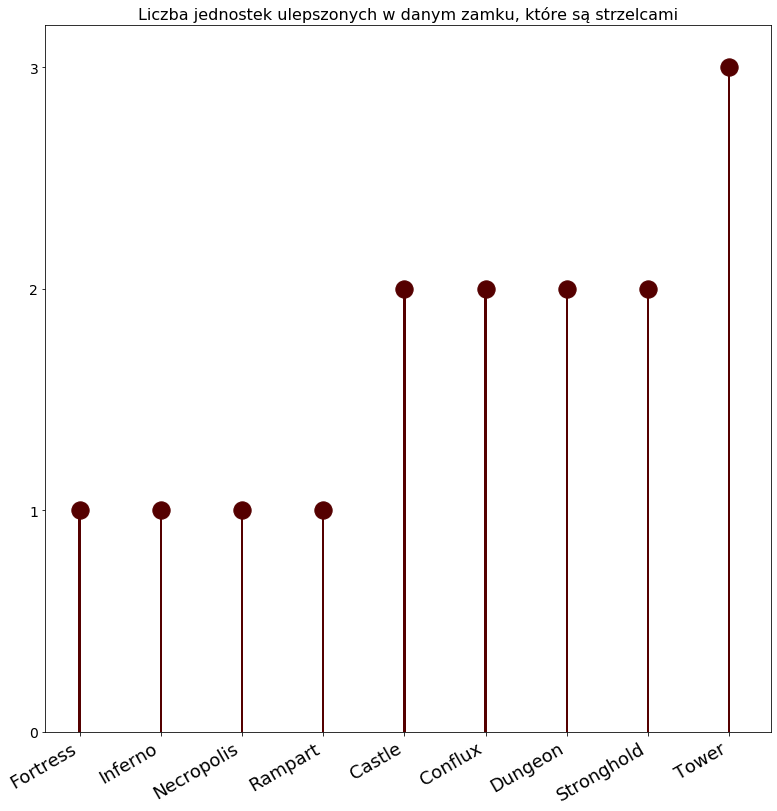

In [64]:
#ranking #2 - lolipop plot - barchart wąski z oznaczonym kropką końcem


df2=df.copy()
k=df2['Special_abilities'].str.contains('Ranged\(')
l=df2['Level'].str.contains('\+')

df2=df2[k&l]
df2['All']=1
df2=df2.groupby(['Castle'], as_index=False).sum().sort_values(by='All')


fig, ax=plt.subplots(1,1)
fig.set_size_inches(13,13)

f=df2.columns.get_loc('All')
for i in range(df2.shape[0]):
    #Tworzę lolipopa jako złożenie barplota i scatterplota - tworzenie takich rzeczy w pętli upraszcza mi customizację
    Z=df2.iat[i,f]
    ax.bar(x=i, height=Z, width=0.03, color='#550000')
    ax.scatter(x=i, y=Z, color='#550000', s=300.1)

ax.set_xticks(range(0,9,1))
ax.set_yticks(range(0,4,1))
ax.set_xticklabels(df2['Castle'], ha='right')
ax.xaxis.set_tick_params(labelsize=18, labelrotation=30)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_title('Liczba jednostek ulepszonych w danym zamku, które są strzelcami', fontsize=16)
#plt.grid(axis='y')

plt.show()

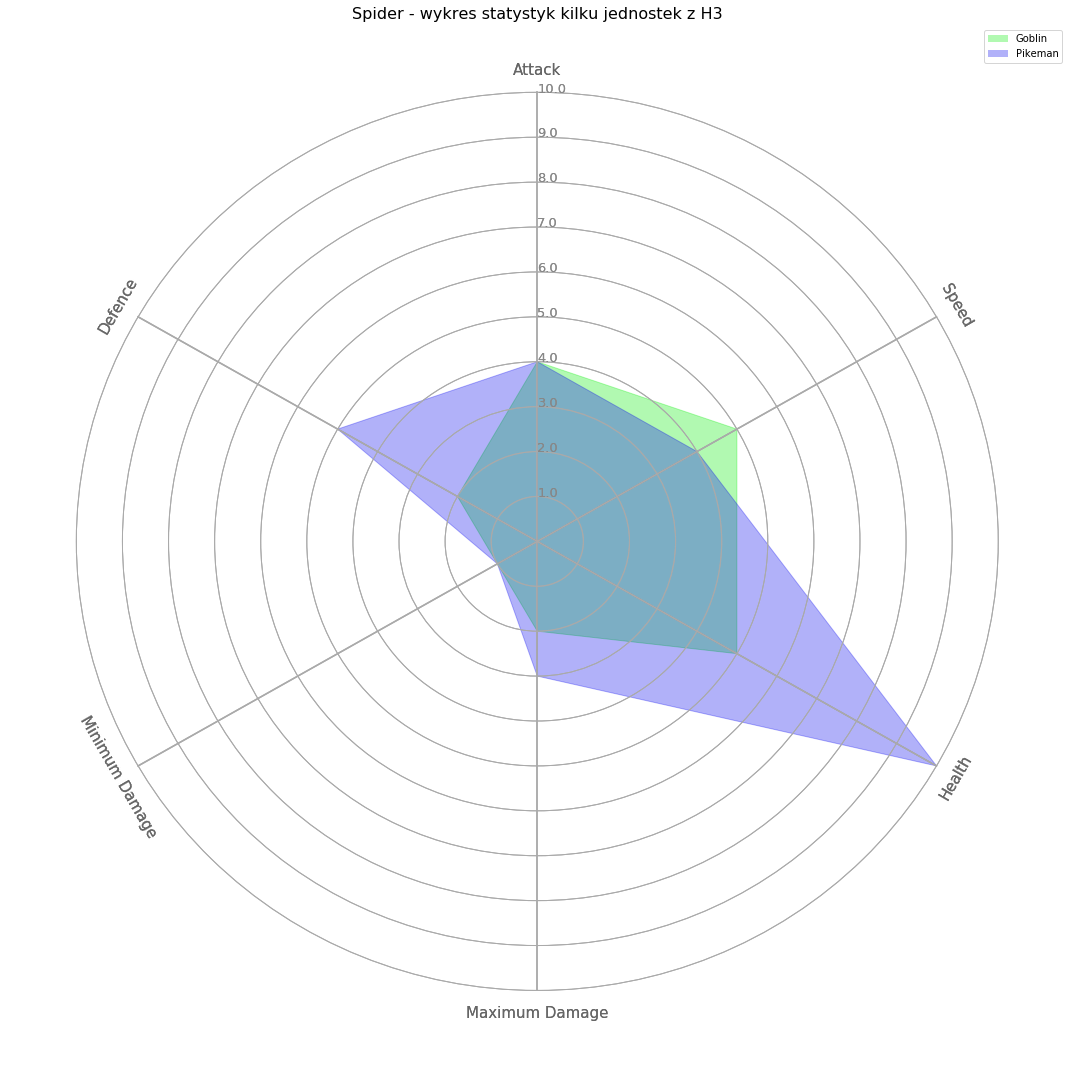

In [65]:
#ranking #3 - Spider

#allez-promień koła, n-liczba promieni radara, m-licba kółek, maxi-najwyższa liczba na radarze, subd-ciąg z labelami, ax-wykres, incol-kolor żłoba, legg-legenda, lab-label
def spiderland(allez, n, m, maxi, subd, ax, incol='#EE0000', legg=[], lab='Nan'):
    #Dodanie do legendy nowego obiektu
    legg.append(Patch(facecolor=incol, alpha=0.3, label=lab))
    
    deg=2*math.pi/n
    x=[0]*n
    y=[allez]*n

    #punkty końca linii radaru
    for i in range(1, n, 1):
        x[i]=x[i-1]*math.cos(deg)-y[i-1]*math.sin(deg)
        y[i]=x[i-1]*math.sin(deg)+y[i-1]*math.cos(deg)

    #Radar
    for i in range(n):
        ax.plot([0, x[i]], [0, y[i]], color='#AAAAAA')

    #Wypełnienie trójkątów
    i=1
    while (i<n):
        ax.fill([0, x[i-1]*int(subd[i-1])/maxi, x[i]*int(subd[i])/maxi], [0, y[i-1]*int(subd[i-1])/maxi, y[i]*int(subd[i])/maxi], alpha=0.3, color=incol)
        i+=1
    ax.fill([0, x[i-1]*int(subd[i-1])/maxi, x[0]*int(subd[0])/maxi], [0, y[i-1]*int(subd[i-1])/maxi, y[0]*int(subd[0])/maxi], alpha=0.3, color=incol)

    #Tekst labeli na kresie spidera
    for i in range(n):
        roth=i*deg*(180/math.pi)
        if (roth>90 and roth<270):
            roth=180+roth
        ax.text(x=x[i]*1.05, y=y[i]*1.05, s=subd.index[i], fontsize=15, color='#666666', rotation=roth, horizontalalignment='center', verticalalignment='center')


    #Kręgi
    crc=[0]*m
    for i in range(m):
        crc[i]=plt.Circle((0,0), allez*(i+1)/m, color='#AAAAAA', fill=None)
        ax.add_artist(crc[i])
        ax.text(x=0, y=allez*(i+1)/m, s=str(maxi*(i+1)/m), fontsize=13, color='#888888')

    ax.set_xlim(-2.3, 2.3)
    ax.set_ylim(-2.3, 2.3)

fig, ax=plt.subplots(1,1)
fig.set_size_inches(19, 19)

leggy=[]
spiderland(2, 6, 10, 10, df[df['Unit_name']=='Goblin'].iloc[0,3:9], ax, incol='#00EE00', legg=leggy, lab='Goblin')
spiderland(2, 6, 10, 10, df[df['Unit_name']=='Pikeman'].iloc[0,3:9], ax, incol='#0000EE', legg=leggy, lab='Pikeman')
ax.legend(handles=leggy)
ax.set_title('Spider - wykres statystyk kilku jednostek z H3', fontsize=16)
ax.axis('off')

plt.show()

#print(df[df['Unit_name']=='Gnoll'].iloc[0,:][2:7])

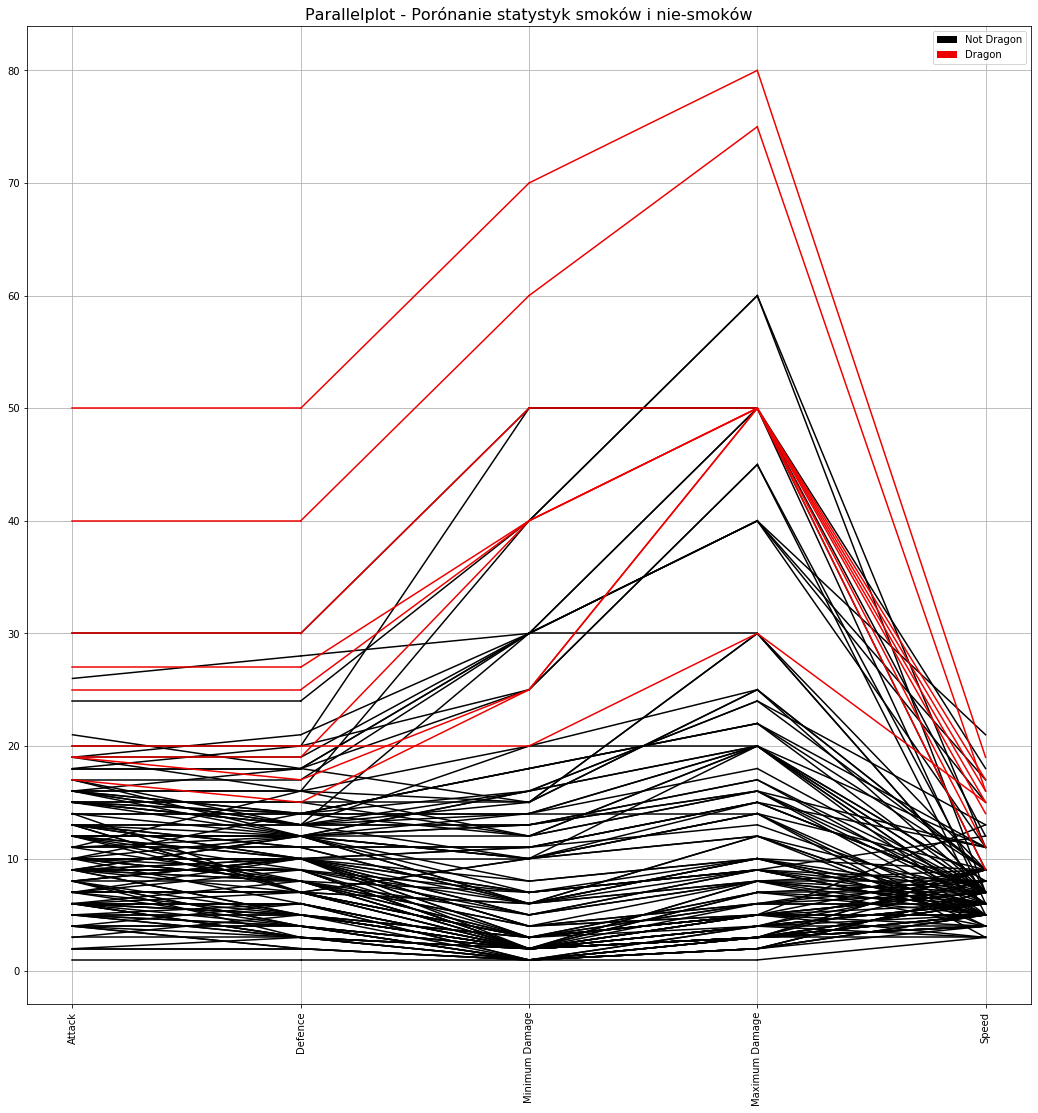

In [66]:
#ranking #4 - parallelplots - lepszy od spidera, bo zamiast współrzędnych polarnych są kartezyańskie
#Pozwala pokazywać dane w dowolnie wysokim wymiarze (podobnie jak spider)
def drawparallels(ax, subd, legg=[], lab='', incol='#EE0000'):
    for j in range(1, subd.shape[0], 1):
        for i in range(1, subd.shape[1], 1):
            ax.plot([i-1, i], [subd.iat[j,i-1], subd.iat[j,i]], color=incol)
    
    legg.append(Patch(facecolor=incol, label=lab)) 
    ax.set_xticks(range(0, subd.shape[1], 1))
    ax.set_xticklabels(subd.columns)
    ax.xaxis.set_tick_params(labelrotation=90)


fig, ax=plt.subplots(1,1)
fig.set_size_inches(18,18)
colors=['#EE0000', '#888800', '#990044', '#EE0088', '#0000EE', '#00EE88', '#000000']
lg=[]

#komentarz - parallelplot z poziomami
#for i in range(1, 8, 1):
#    mdf=df[(df['Level']==str(i)) | (df['Level']==str(i)+'+')].iloc[:,[3,4,5,6,8]]
#    drawparallels(ax, mdf, legg=lg, lab=str(i), incol=colors[i-1])

#print(df[(df['Level']==str(i)) | (df['Level']==str(i)+'+')])


k=df['Unit_name'].str.contains('Dragon$')
k[k.isna()]=False
k=k.astype('bool')

mdf=df[np.invert(k)].iloc[:,[3,4,5,6,8]]
drawparallels(ax, mdf, legg=lg, lab='Not Dragon', incol=colors[6])
mdf=df[k].iloc[:,[3,4,5,6,8]]
drawparallels(ax, mdf, legg=lg, lab='Dragon', incol=colors[0])

ax.legend(handles=lg)
ax.set_title('Parallelplot - Porónanie statystyk smoków i nie-smoków', fontsize=16)
ax.grid()
plt.show()

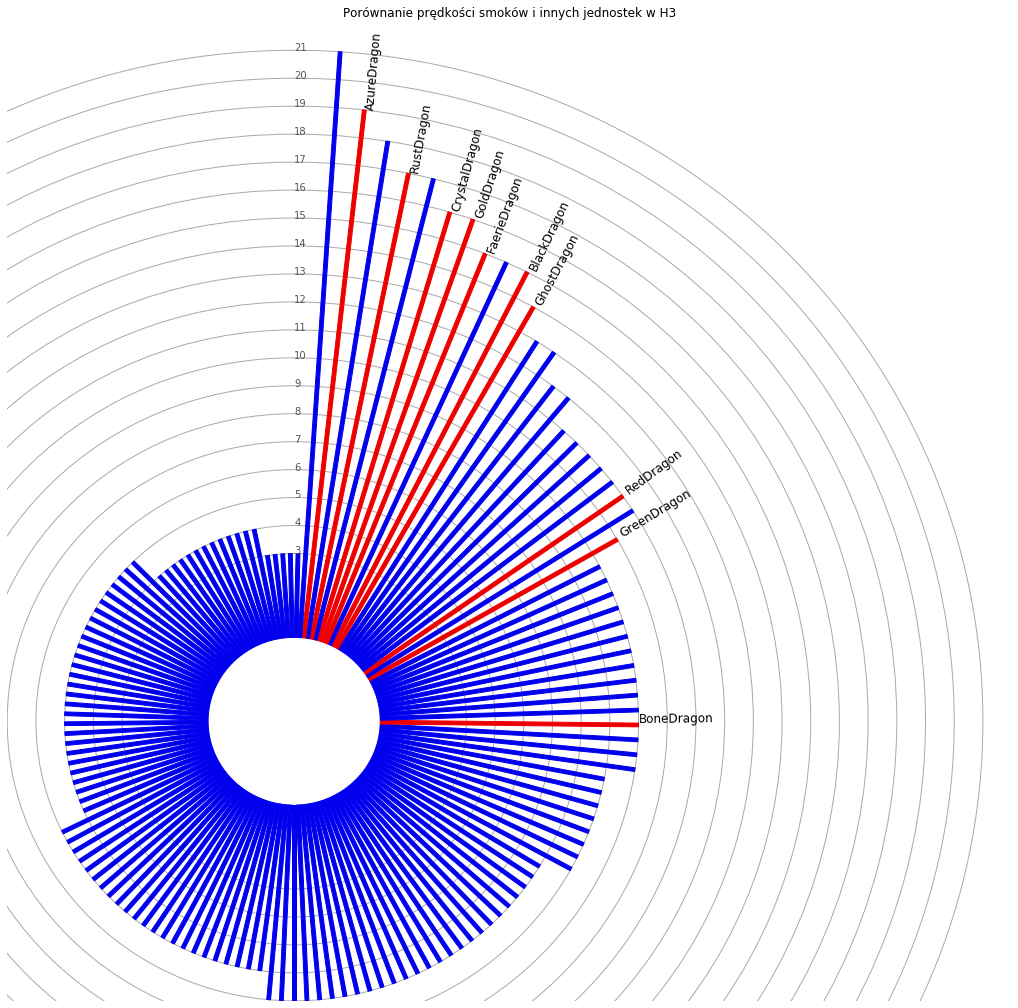

In [67]:
#Ranking #5 - kołowy barplot - dosyć ekstrawagancji, problemy analogiczne jak ze spiderplotem
#Wykres przedstawia zestawienie szybkości jednostek w H3 z wyróżnieniem smoków

fig, ax=plt.subplots(1,1)
fig.set_size_inches(18,18)

def dist(x1, x2, y1, y2):
    return (math.sqrt((x1-x2)*(x1-x2)+(y1-y2)*(y1-y2)))

#ax- oś, heights - wysokości barów, colors - kolory (lista/element - domyślnie wszystkie takie same), analogicznie labels, Rad - promień wnętrznego koła
def circlebar(ax, heights, colors='#EE0000', labels='', Rad=3):
    if (type(colors)==type('star')):
        colors=[colors]*len(heights)
    if (type(labels)==type('star')):
        labels=[labels]*len(heights)
    N=len(heights)
    
    x=[0]*N
    y=[Rad]*N
    deg=2*math.pi/N
    degn=360/N
    
    #Ręcznie napisany radar - może kiedyś domknę go w argumencie funkcji
    for i in range(6, 25, 1):
        f=plt.Circle((0,0), i, fill=None, color='#AAAAAA')
        ax.add_artist(f)
        ax.text(x=0, y=i, s=str(i-Rad), color='#555555')
    
    #Dodanie kolejnych barów ze wzoru na macierz rotacji: https://en.wikipedia.org/wiki/Rotation_matrix
    #Nie używam ax.bar, ale figur geometrycznych - to upraszcza rotację
    for i in range(1, N, 1):
        x[i]=math.cos(deg)*x[i-1]-math.sin(deg)*y[i-1]
        y[i]=math.sin(deg)*x[i-1]+math.cos(deg)*y[i-1]
        f=plt.Rectangle(xy=(x[i],y[i]), width=dist(x[i-1],x[i],y[i-1],y[i]), height=heights[i],
                        angle=(2*i-1)*degn/2, color=colors[i])
        ax.add_artist(f)
        #ax.text(x=(x[i])*(2+heights[i])/2, y=(y[i])*(2+heights[i])/2, s=labels[i], fontsize=12, rotation=i*degn+90, verticalalignment='bottom', horizontalalignment='left')
        ax.text(x=(x[i]+x[i-1])*(Rad+heights[i])/(2*Rad), y=(y[i]+y[i-1])*(Rad+heights[i])/(2*Rad), s=labels[i], fontsize=12, rotation=i*degn+90, verticalalignment='bottom', horizontalalignment='left')
        
    f=plt.Rectangle(xy=(x[0],y[0]), width=dist(x[N-1],x[0],y[N-1],y[0]), height=heights[0],
                    angle=(-1)*degn/2, color=colors[0])
    ax.add_artist(f)
    ax.text(x=x[i]*(2+heights[0])/2, y=y[i]*(2+heights[0])/2, s=labels[0], fontsize=12, rotation=0*degn+90)
    
    return


df2=df.copy()
df2.sort_values(by='Speed', inplace=True)

df2.index=range(0,df2.shape[0],1)
k=df2['Unit_name'].str.contains('Dragon$')

df2['Coll']='#0000EE'
df2.loc[k,'Coll']='#EE0000'
df2['Lab']=''
df2.loc[k,'Lab']=df2.loc[k,'Unit_name']

circlebar(ax, heights=df2['Speed'], colors=df2['Coll'], labels=df2['Lab'])

ax.set_title('Porównanie prędkości smoków i innych jednostek w H3')
ax.set_xlim(-10,25)
ax.set_ylim(-10,25)
ax.axis('off')

plt.show()

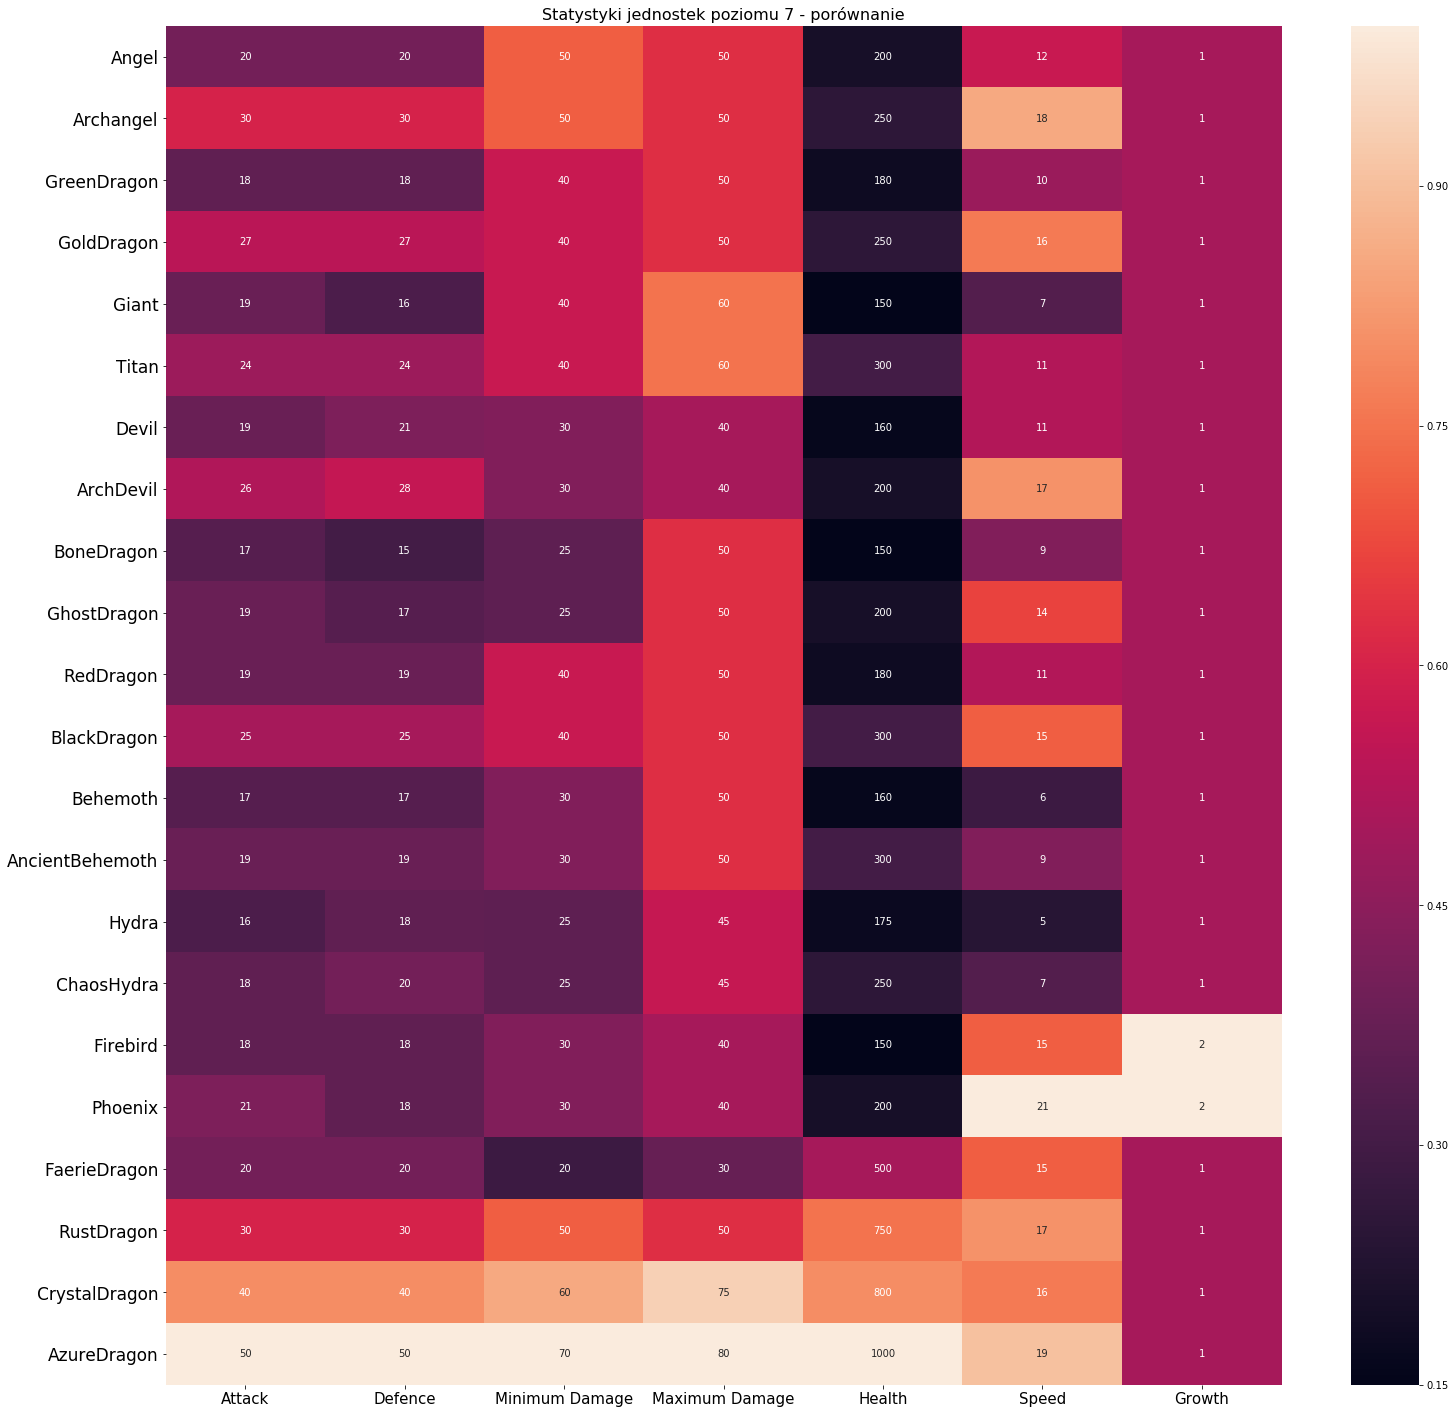

In [68]:
#Korelacja #3 - heatmap z normalizacją (proporcje z przedziału 0-1)
#legenda pokazuje proporcje (Im jaśniej, tym większa wartość w kolumnie)
def besserheatmap(df, ax, labels=2.312, ant=False):
    #Proporcja - normalizacja wartości w kolumnie - bez tego wszystko byłoby prawie czarne, bo max(health)=1000 ma wiele większą wartość niż pozostałe staty
    for i in range(0, df.shape[1], 1):
        mn=df.iloc[:,i].max()
        df.iloc[:,i]=df.iloc[:,i]/mn
    
    #Tworzenie mapy i skal na osi, fmt='d' - format na zwykły digit
    sns.heatmap(data=df, ax=ax, annot=ant, fmt='d')
    ax.yaxis.set_tick_params(labelrotation=0, labelsize=17)
    ax.xaxis.set_tick_params(labelrotation=0, labelsize=15)
    ax.set_ylim(df.shape[0], 0)
    
    #Szczegóły (ticks - te małe kreski - skala) na osi y
    x=[0.5]*df.shape[0]
    for i in range(1, len(x), 1):
        x[i]=x[i-1]+1
    ax.set_yticks(x)
    ax.set_ylim(df.shape[0], 0)
    
    #Czy podano argument 'labels'? Zrobiłem to kompletnie dziadowsko, ale działa
    if (type(labels)!=type(2.13)):
        ax.set_yticklabels(labels)
    
    

fig, ax=plt.subplots(1,1)
fig.set_size_inches(25,25)

df2=df[(df['Level']=='7') | (df['Level']=='7+')]
GG=df2.loc[:,df.dtypes=='int64']
lGG=df2.loc[:,'Unit_name']
GG=GG.iloc[:,0:7]

besserheatmap(df=GG, ax=ax, labels=lGG, ant=GG.copy())
ax.set_title('Statystyki jednostek poziomu 7 - porównanie', fontsize=16)

plt.show()

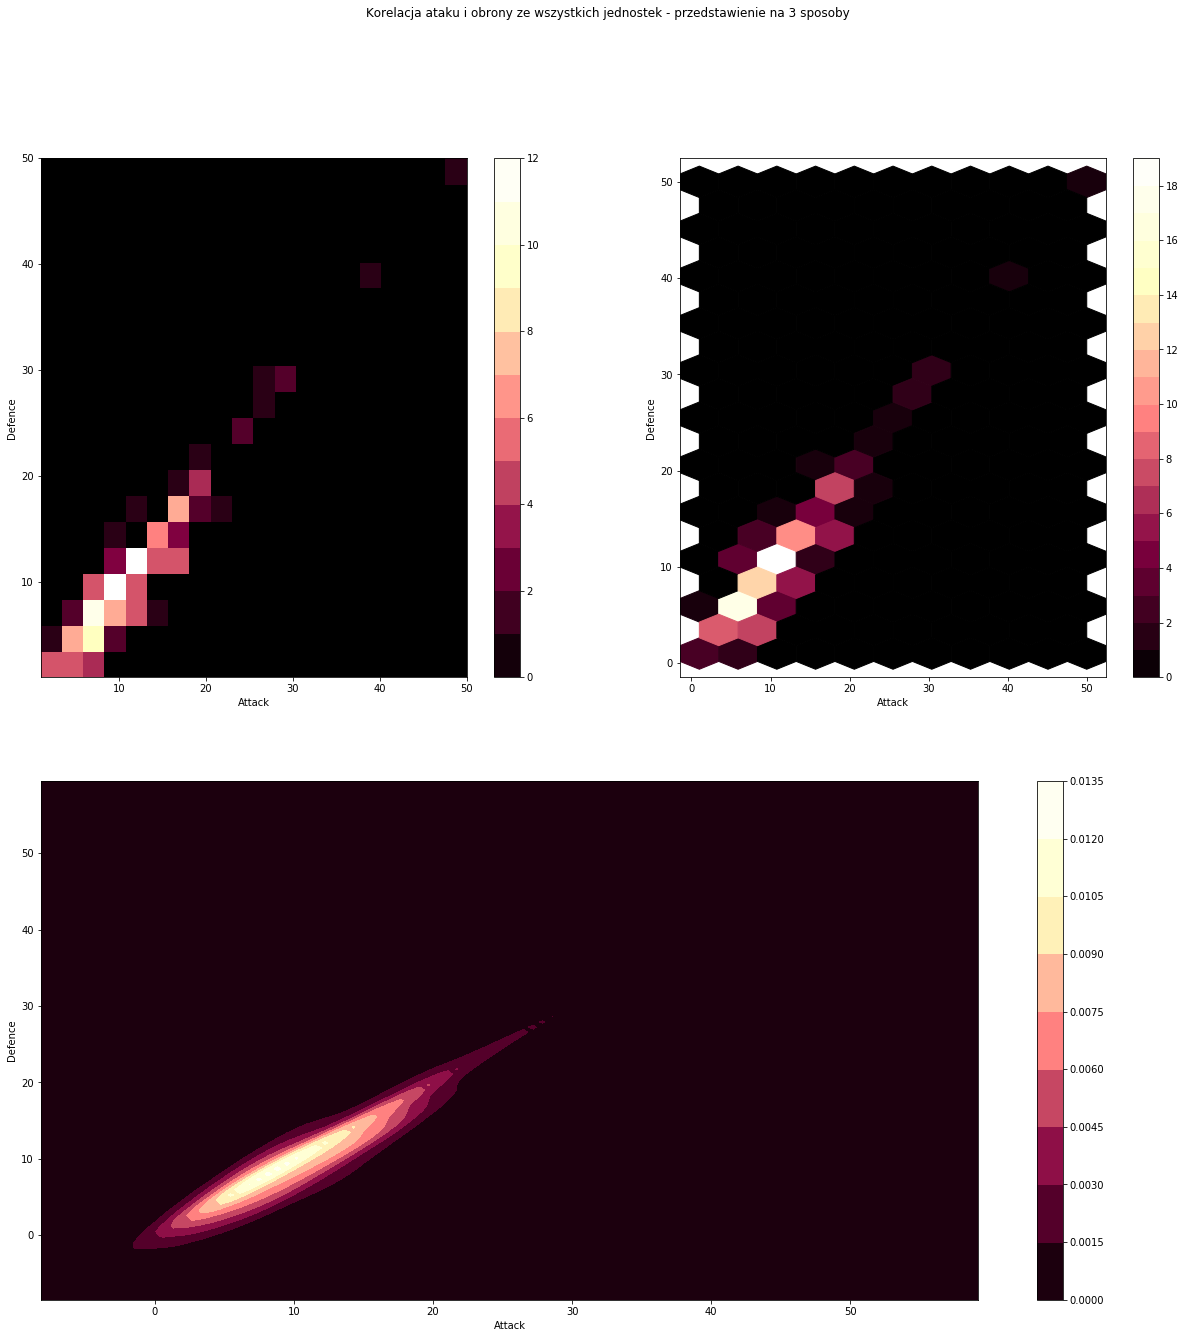

In [69]:
#Korelacja #4 - Denstity ploty na 4 sposoby - 2-wymiarowy histogram/hex bins/kde dentsity/contour(seaborn)
#Wykres ten nadaje się do analizy dużej ilości danych - w tym datasecie to nie zachodzi, ale w większych punkty się nakładają i scatterplot nie obrazuje dobrze dataframe'a
#Wykres przedstawia korelacje ataku i obrony ze wszystkich jednostek

#dictionary wzięty żywcem z dokumentacji LinearSegmentedColormap - Zwykła randomizacja jest trefna w tego typu wykresie, daje świat malowany odcieniami szarości
#Tworzenie własnej Cmapy - nie rozszyfrowałem sensu argumentu 'name', dict (x,y1,y2) interpoluje przedział x[i-1]:x[i] -> y[i-1][2]:y[i][1]
cdict = {'red':   [(0.0,  0.0, 0.0),
                   (0.5,  1.0, 1.0),
                   (1.0,  1.0, 1.0)],

         'green': [(0.0,  0.0, 0.0),
                   (0.25, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0,  1.0, 1.0)],

         'blue':  [(0.0,  0.0, 0.0),
                   (1.0,  1.0, 1.0)]}
z=matplotlib.colors.LinearSegmentedColormap(name='Kappa', segmentdata=cdict)


X=df['Attack']
Y=df['Defence']
#Gridspec - pozwala podzielić mi wykres jak mi się żywnie podoba
gs=gridspec.GridSpec(2,2)
fig, ax=plt.subplots(2,2, figsize=(21,21))

h1=ax[0][0].hist2d(X, Y, bins=(20, 20), cmap=z)

#Szukam Maxa i mina wśród wartości histogramu 2-wymiarowego, w odniesieniu do nich tworzę colorbar
mn=1000; mx=0
for i in range(0, len(h1[0]), 1):
    for j in range(0, len(h1[0][i]), 1):
        mn=min(h1[0][i][j], mn)
        mx=max(h1[0][i][j], mx)
        
Z = [[0,0],[0,0]]
levels = range(int(mn),int(mx)+1,1)
Map1 = plt.contourf(Z, levels, cmap=z)
#teoretycznie tu powinienem usunąć ten wykres powyżej, ale on i tak jest zakryty (plt.clear())
fig.colorbar(Map1, ax=ax[0][0])


#Analogicznie dla hexbina
g=ax[0][1].hexbin(X, Y, gridsize=(10,10), cmap=z)
g=g.get_array()
mn=1000; mx=0
for i in range(0, len(h1[0]), 1):
    mn=min(g[i], mn)
    mx=max(g[i], mx)
levels = range(int(mn),int(mx)+1,1)
Map2 = plt.contourf(Z, levels, cmap=z)
fig.colorbar(Map2, ax=ax[0][1])

#Łączenie 2 części figury - teraz ma je ax[1][0], następnie wykres - kdeplot w 2 wymiarach
ax[1][0]=plt.subplot(gs[1, :])
sns.kdeplot(data=X, data2=Y, ax=ax[1][0], cmap=z, shade=True, cbar=True)

#Ustawiam tytuły osi
for i in range(0, 3, 1):
    ax[i//2][i%2].set_xlabel('Attack')
    ax[i//2][i%2].set_ylabel('Defence')

fig.suptitle('Korelacja ataku i obrony ze wszystkich jednostek - przedstawienie na 3 sposoby')


plt.show()

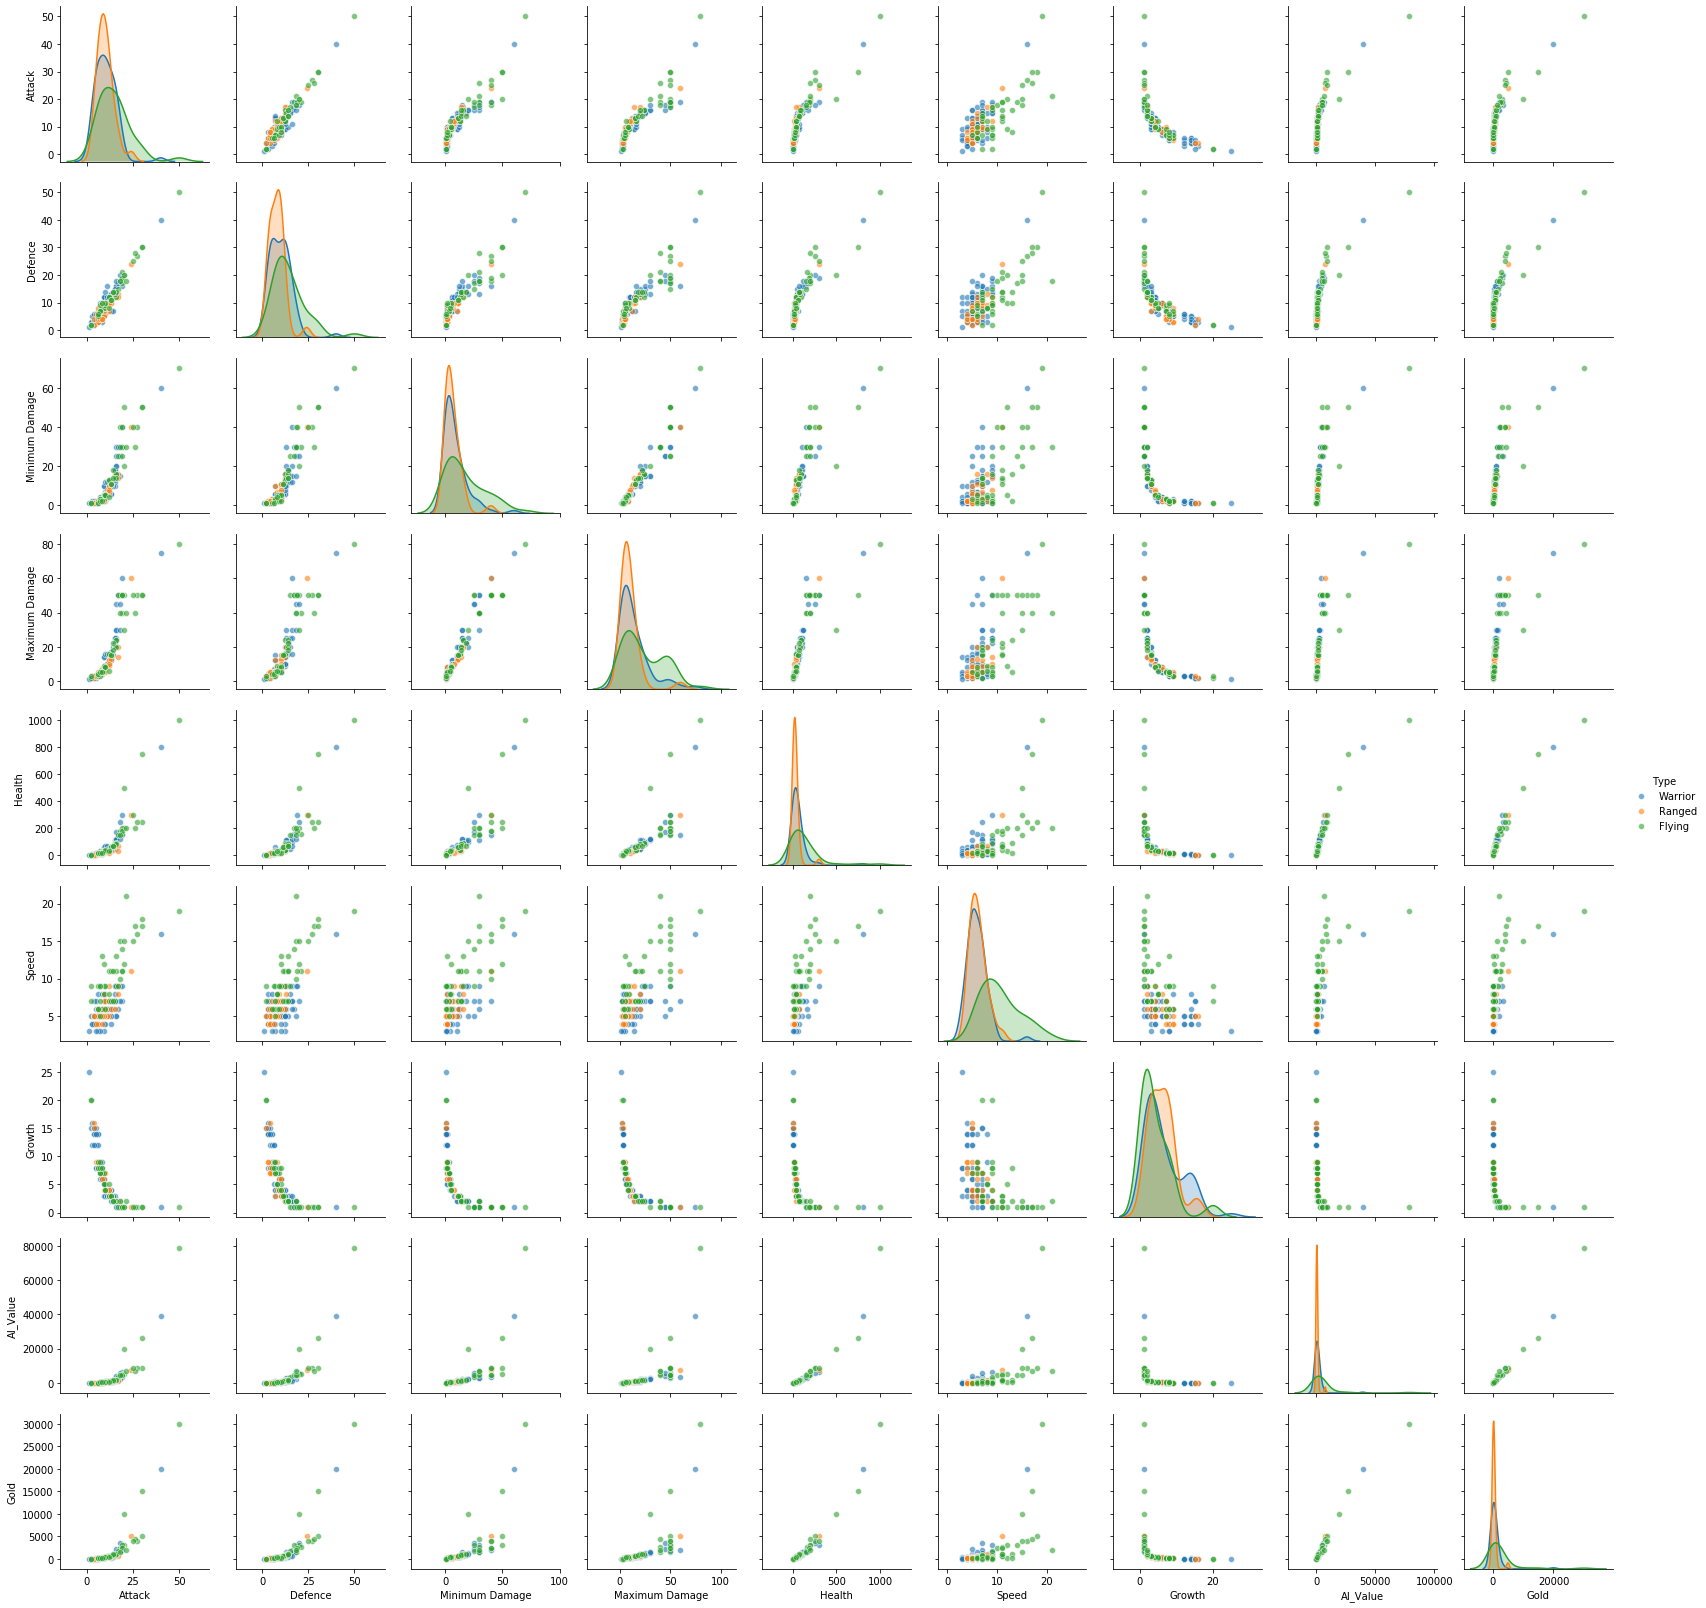

In [96]:
#Korelacja #5 - correlogram - pozwala przeanalizować cały dataset na 1 wykresie. Bardzo odporny na modyfikacje, nie ma też zbyt wielu powodów, by je wprowadzać
#Plot_kws pozwala mi zmienić widoczność kropek(obserwacji) - i tak jest lipna, jednostek typu ranged jest mniej niż warriorów, czego nie widać
sns.pairplot(df, hue='Type', diag_kind='kde', plot_kws={'alpha':0.6})
plt.show()

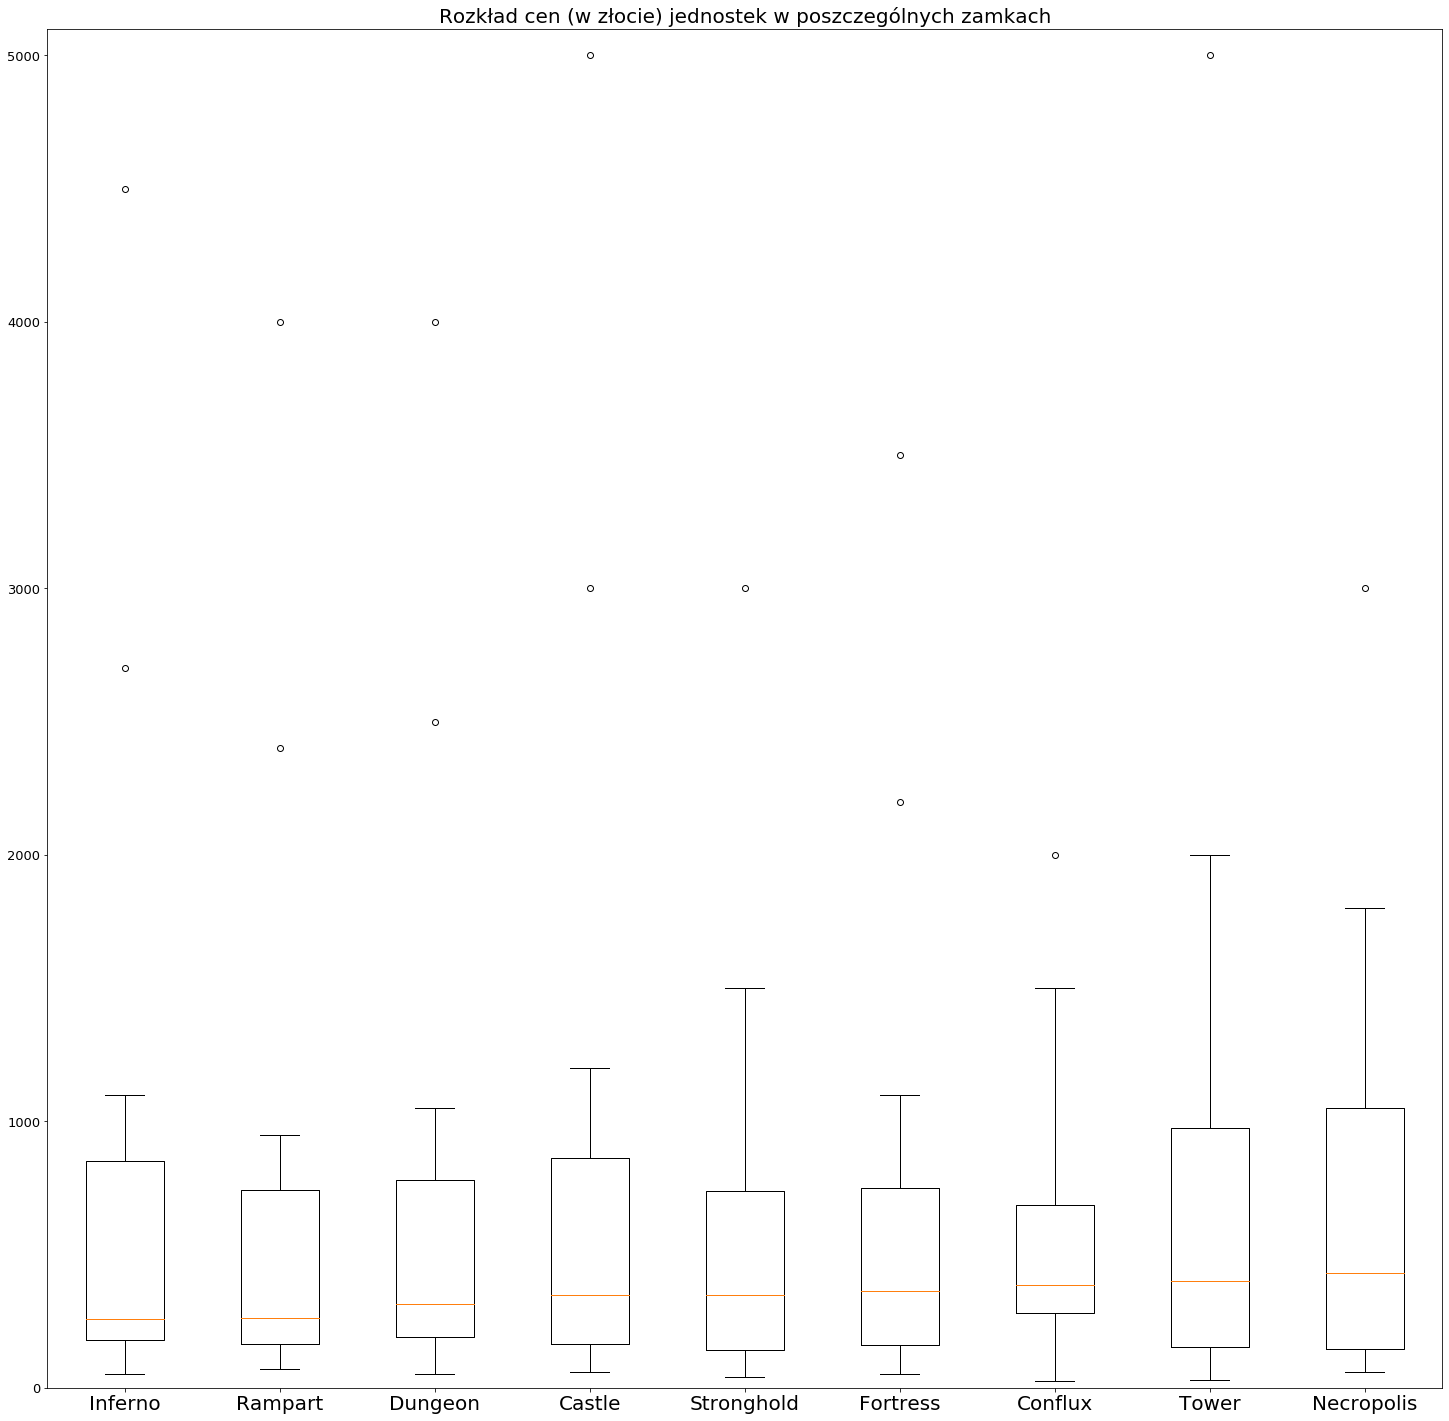

In [70]:
#Dystrybucja #1 - boxplot - rozkład cen (w złocie) jednostek w poszczególnych zamkach - po 1 każdego rodzaju (po 14 obserwacji w 1 kolumnie)
#Boxplot: linia środkowa - mediana, box to odstęp pomiędzy I i III kwartylem, warkocz to min(max_obs, Q3+IQR*2) i max(min_obs, Q1-IQR*2) gdzie IQR - rozstęp międzykwartylowy
df2=df.loc[:,['Castle', 'Gold']]
df3=df2.groupby(['Castle'], as_index=False).median().sort_values(by='Gold')
k=df3['Castle']
k=k[k!='Neutral']

"""
k=np.unique(df['Castle'])
k=k[k!='Neutral']"""
l1=[0]*len(k)
for i in range(len(k)):
    l1[i]=df2[df2['Castle']==k[k.index[i]]].loc[:,'Gold']

fig, ax=plt.subplots(1,1)
fig.set_size_inches(25,25)
ax.boxplot(l1, labels=k, whis=2)
ax.set_ylim(0, 5100)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=13)
ax.set_title('Rozkład cen (w złocie) jednostek w poszczególnych zamkach', fontsize=20)
plt.show()

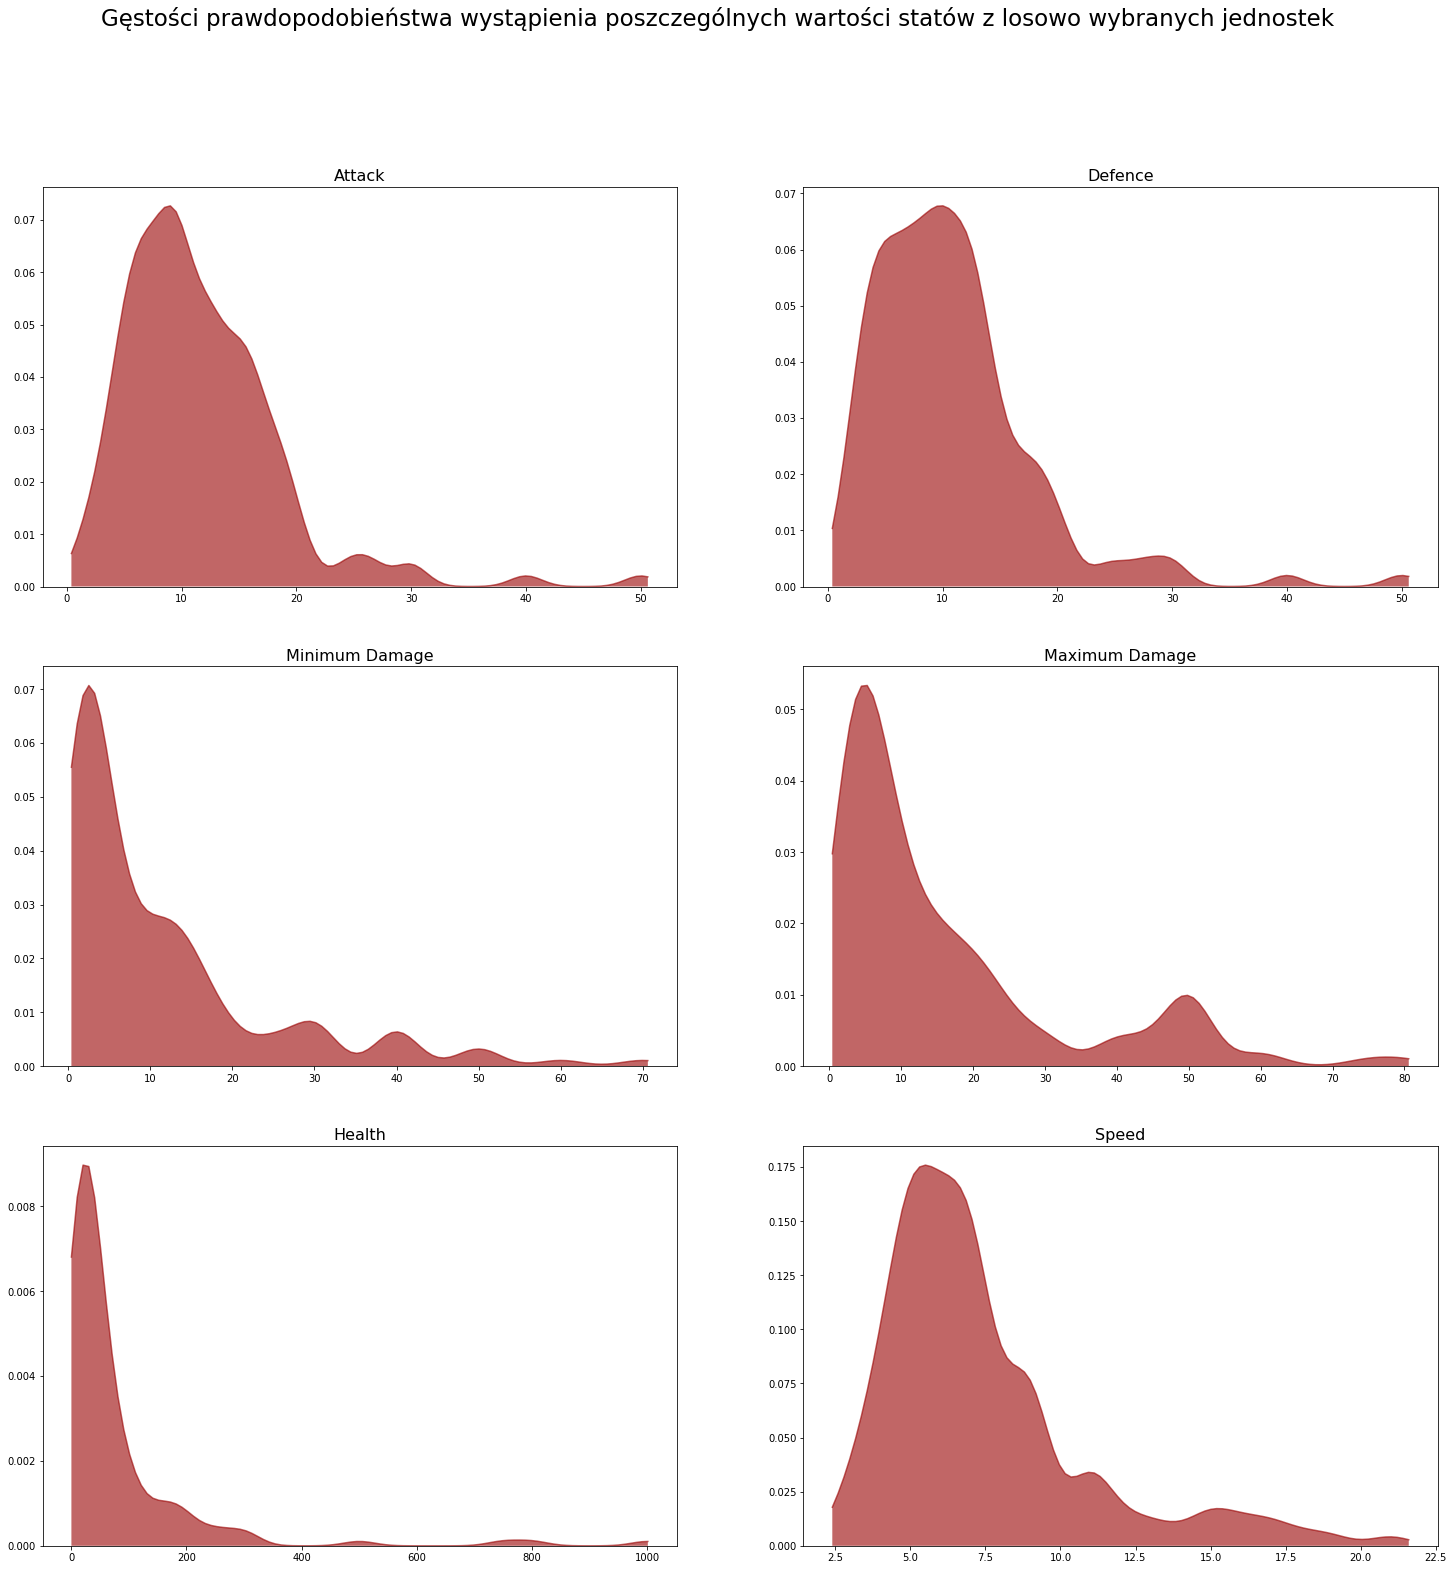

In [71]:
#Dystrybucja #3 - density plot w 1 wymiarze - lepsza wersja histogramu
#Gęstości prawdopodobieństwa wystąpienia poszczególnych wartości statów z losowo wybranych jednostek - czyli de facto wygłądzony histogram wyliczony z kernel density estimation
#Rozmiar 'binów' można modelować za pomocą parametru bw
fig, ax=plt.subplots(3, 2)
fig.set_size_inches(25,25)

for j in range(0, 6, 1):
    fax=ax[j//2][j%2]
    sns.kdeplot(data=df.loc[:,df.columns[3+j]], ax=fax, shade=True, bw=0.2, alpha=0.6, color='#990000')
    fax.set_title(df.columns[3+j], fontsize=16)
    fax.get_legend().remove()
fig.suptitle('Gęstości prawdopodobieństwa wystąpienia poszczególnych wartości statów z losowo wybranych jednostek', fontsize=23)
plt.show()

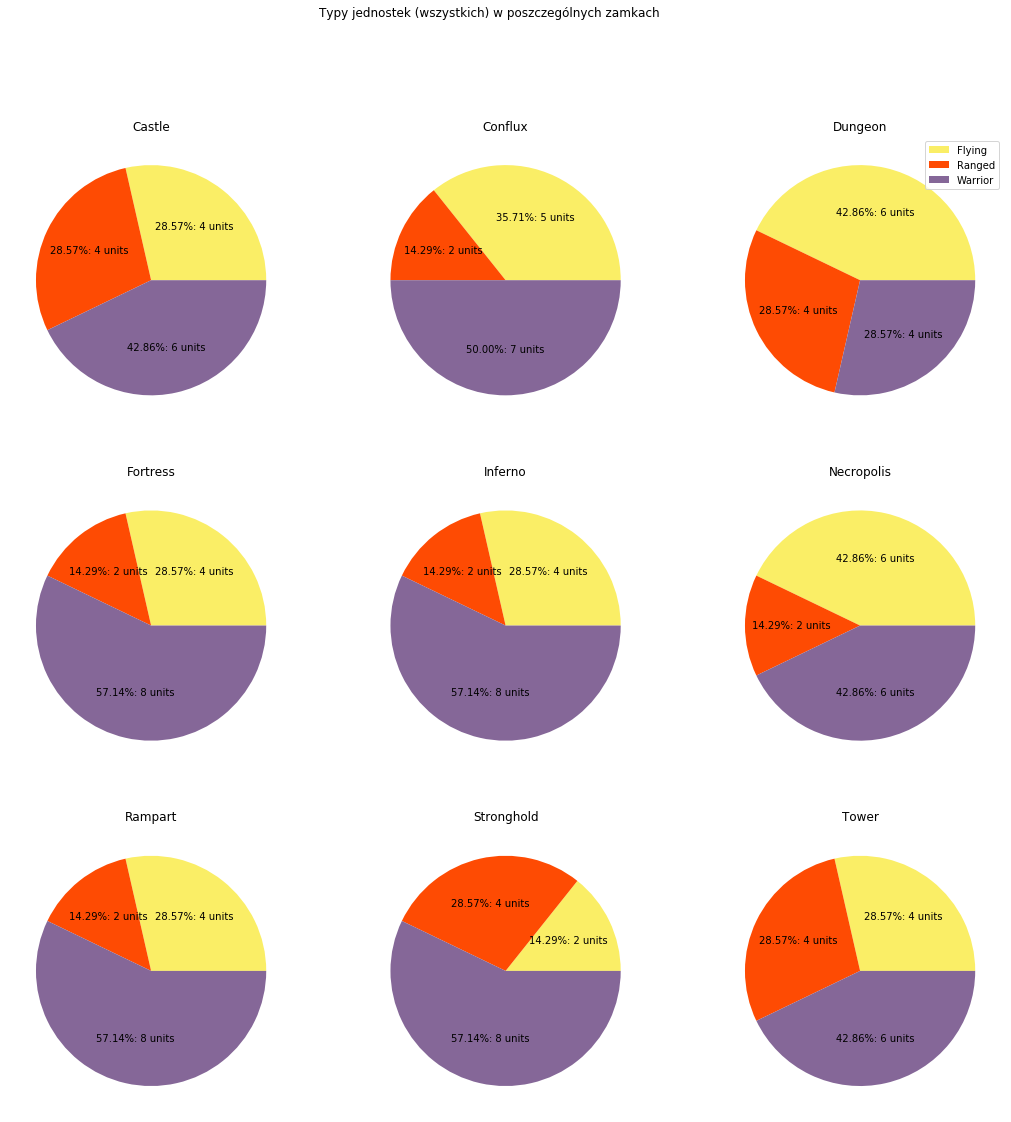

In [72]:
#Część całości #2 - pie chart - najgorszy możliwy wykres, nie dość, że kołowy i wymusza porównywanie powierzchni (do czego ludzkie oko się nie nadaje), to jeszcze brzydki
#W tym wykresie porównuję różne typy jednostek w poszczególnych zamkach. Wykres jest koszmarny, ale to immanentna cecha piecharta. Stacked barplot byłby zdecydowanie lepszy, ale chciałem zaprezentować piecharta

df2=df.copy()
df2['All']=1

df3=df2.groupby(['Castle', 'Type'], as_index=False).count()

fig, ax=plt.subplots(3,3, figsize=(18,18))
castles=np.unique(df2['Castle'])
castles=castles[castles!='Neutral']

#Iteracja po wszystkich axach (osie)
for i in range(0, 3, 1):
    for j in range(0, 3, 1):
        adf=df3[df3['Castle']==castles[i*3+j]]
        fa=ax[i][j]
        fa.set_title(castles[i*3+j])
        #Jedyna ciekawa rzecz w tym wykresie: formatowanie stringa - funkcja, która bierze procenty, wypluwa sformatowany output
        fa.pie(x=adf['All'], labels=adf['Type'], labeldistance=None, colors=['#FAEE66', '#FE4B03', '#856798'], autopct=lambda perc: ('%.2f%s: %d units' %(perc, '%', round(perc*sum(adf['All'])/100,0))))
        fa.axis('off')
    
ax[0][2].legend()
fig.suptitle('Typy jednostek (wszystkich) w poszczególnych zamkach')
plt.show()

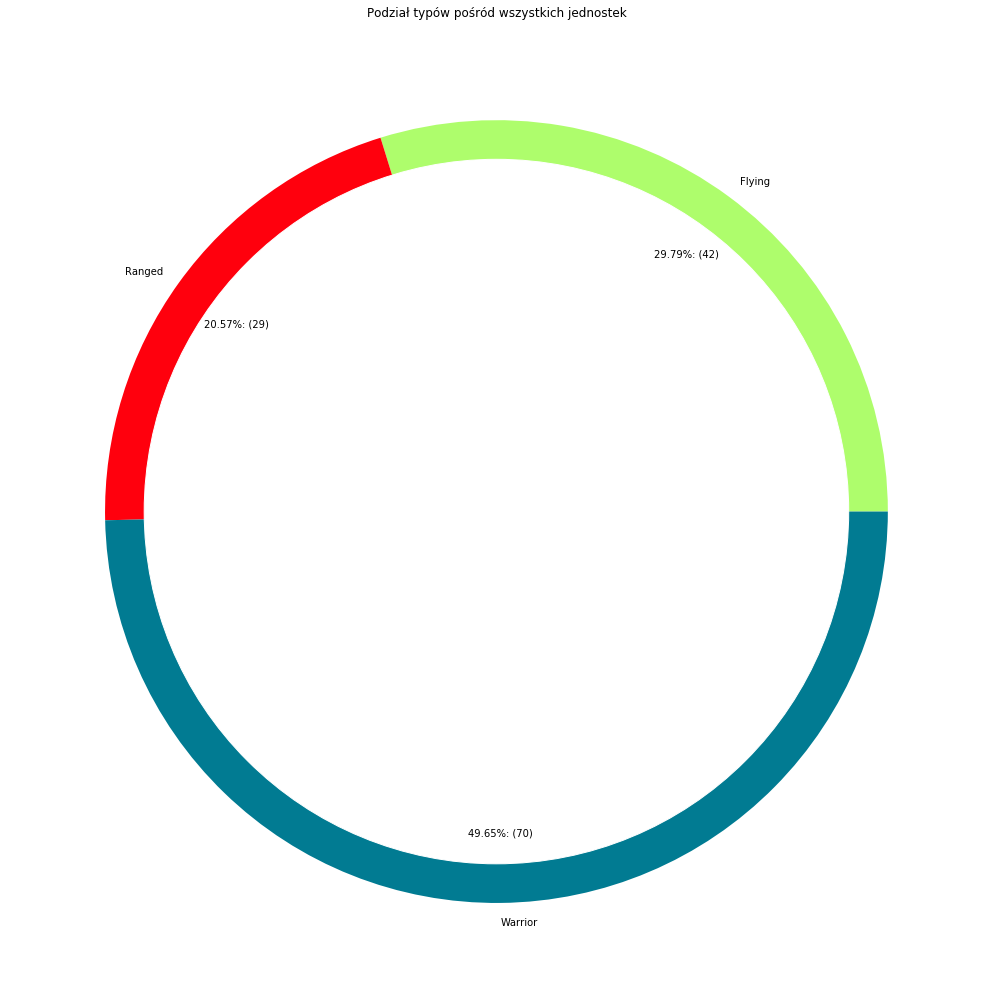

In [73]:
#Część całości #3 - donut plot - lepszy niż pie chart, bo porównuję długości
#Wykres analogiczny jak poprzedni, ale bez podziału na zamki
df2=df.copy()
df2['All']=1
df3=df2.groupby(['Type'], as_index=False).count()

fig, ax=plt.subplots(1,1,figsize=(18,18))
ax.pie(x=df3['All'], labels=df3['Type'], labeldistance=1.05, colors=['#AEFD6C', '#FF000D', '#017B92'], autopct=lambda perc: ('%.2f%s: (%d)' %(perc, '%', round(perc*sum(df3['All'])/100,0))), pctdistance=0.82)
f=plt.Circle((0,0), 0.9, color='#FFFFFF')
ax.add_artist(f)
ax.set_title('Podział typów pośród wszystkich jednostek')

plt.show()

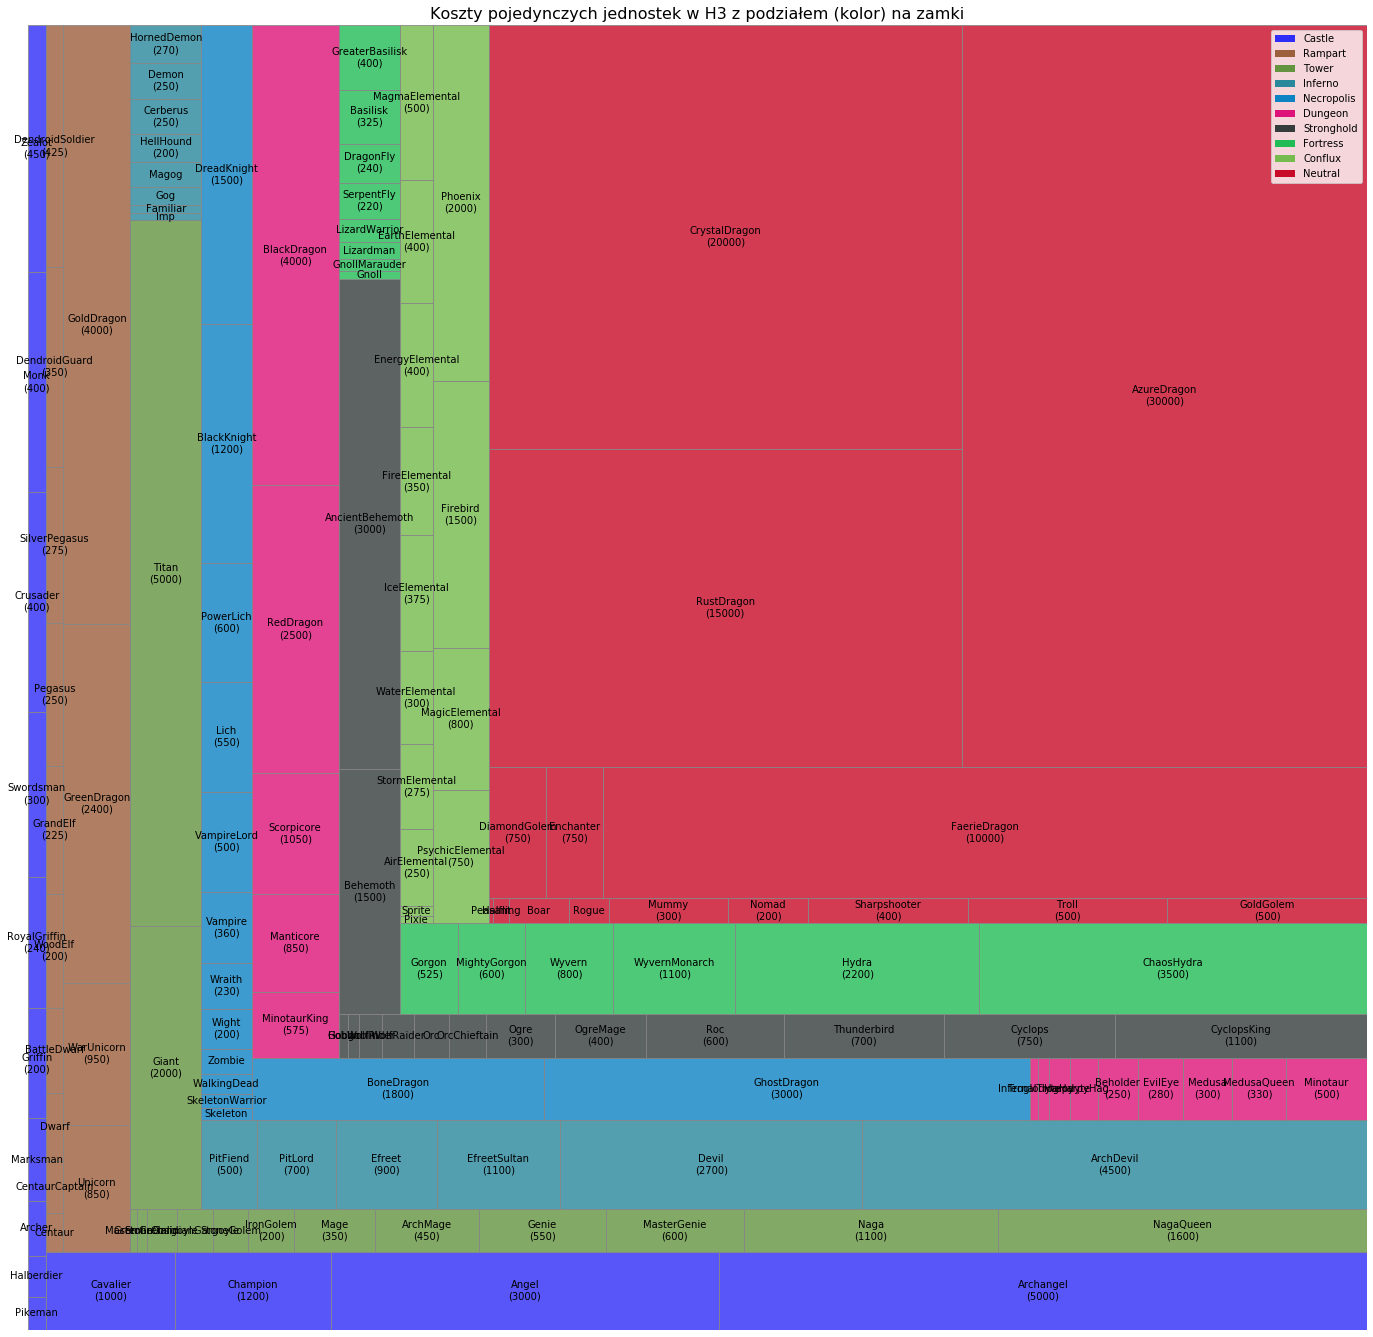

In [82]:
#Część całości #4 - Treeplot - pozwala on (podobnie jak subburst czy dendrogram) analizować w całości zbiory hierarchiczne - z podziałem na podzbiory
#Ten wykres nie jest idealny - byłby taki, gdybym sam sobie implementował funkcję tworzącą treemapę, ale mi się tego nie chce -
#Kolejne obserwacje powinny być obok siebie, układać się w 'węża' - gdybym ja to implementował
#Mogłem stworzyć ładniejszy wykres z mniejszą ilością obserwacji, ale wolałem sprawdzić, jak się customizuje treeplota i pcha kolory do wykresu
#Wykres pokazuje porównanie kosztu w złocie dla wszystkich jednostek z podziałem na zamki; pomijam koszty tanich jednostek, dzięki temu wykres jest względnie czytelny
#Najciekawszą rzeczą z tego wykresu jest rozrzut między cenami 3 smoków a pozostałych 139 jednostek

#string to int z 2 slotami - hexadecimal to decimal
def hextodec(a):
    x=0; clr=0; av=1
    L=len(a)
    
    for i in range(L):
        clr=ord(a[L-i-1])
        if (clr>=65):
            clr-=55
        else:
            clr-=48
        x=x+av*clr
        av*=16
    return x

#integer to string z 2 slotami - decimal to hexadecimal
def dectohex(a):
    l=[0]*2
    
    for i in range(2):
        x=a%16
        if (x<10):
            l[1-i]=chr(x+48)
        else:
            l[1-i]=chr(x+55)
        a=a//16
    return ''.join(l)

#interpolacja kolorów - biorę n kolorów pomiędzy kolorem a(hex - np. '#EE8800'), a kolorem b
def colorize(a, b, n):
    l=[0]*n
    d=[0]*3
    a1=[0]*3
    
    for i in range(0,3,1):
        f1=a[1+i*2:3+i*2]
        f2=b[1+i*2:3+i*2]
        a1[i]=f1=hextodec(f1)
        f2=hextodec(f2)
        d[i]=(f2-f1)//n
    
    for i in range(0, n, 1):
        l[i]='#'
        for j in range(0, 3, 1):
            l[i]+=dectohex(a1[j])
            a1[j]+=d[j]
    return l

#Stworzenie 2 randomowych kolorów o różnicy w 1 wymaiarze rzędu diff - przydatne do interpolowania kolorów
def gen_rand_colors(diff):
    if (diff>128):
        diff=128
    
    l=[0]*3
    l2=[0]*3
    
    for i in range(0,3,1):
        l[i]=l2[i]=np.random.randint(0,256)
    x=np.random.randint(0,3)
    if (l[x]<=255-diff):
        l2[x]=l[x]+diff
    else:
        l2[x]=l[x]-diff
    
    s1='#'; s2='#'
    for i in range(0,3,1):
        s1+=dectohex(l[i])
        s2+=dectohex(l2[i])
    return (s1, s2)



df2=df.copy()
df2['All']=1
df2['Kappa']=df2.index

df2=df2.groupby(['Castle'], as_index=False).sum().sort_values(by='Kappa')
#print(df2)


fig, ax=plt.subplots(1,1)
fig.set_size_inches(24,24)

clr=[]
lg=[]
Z=df2.columns.get_loc('All')
W=df2.columns.get_loc('Castle')
for i in range(0, df2.shape[0], 1):
    s1, s2=gen_rand_colors(90)
    #clr.extend(colorize(s1, s2, df2.iat[i,Z])) #interpolacja po kolorach - nie polecam, rozmywa się efekt porównania zamków
    clr.extend(colorize(s1, s1, df2.iat[i,Z]))
    lg.append(Patch(facecolor=s1, label=df2.iat[i,W]))
#print(len(clr))

lb=df['Unit_name']+'\n('+df['Gold'].astype(str)+')'
for i in range(0, len(lb), 1):
    if (df.at[i,'Gold']<200):
        lb[i]=df.at[i,'Unit_name']
        
squarify.plot(sizes=df['Gold'], label=lb, alpha=0.8, ax=ax, color=clr, text_kwargs={'fontsize': 10}, bar_kwargs={'fill': True, 'edgecolor': '#888888'})
ax.set_title('Koszty pojedynczych jednostek w H3 z podziałem (kolor) na zamki', fontsize=16)
ax.axis('off')
ax.legend(handles=lg)

plt.show()

C:\Users\Dom\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # This is added back by InteractiveShellApp.init_path()


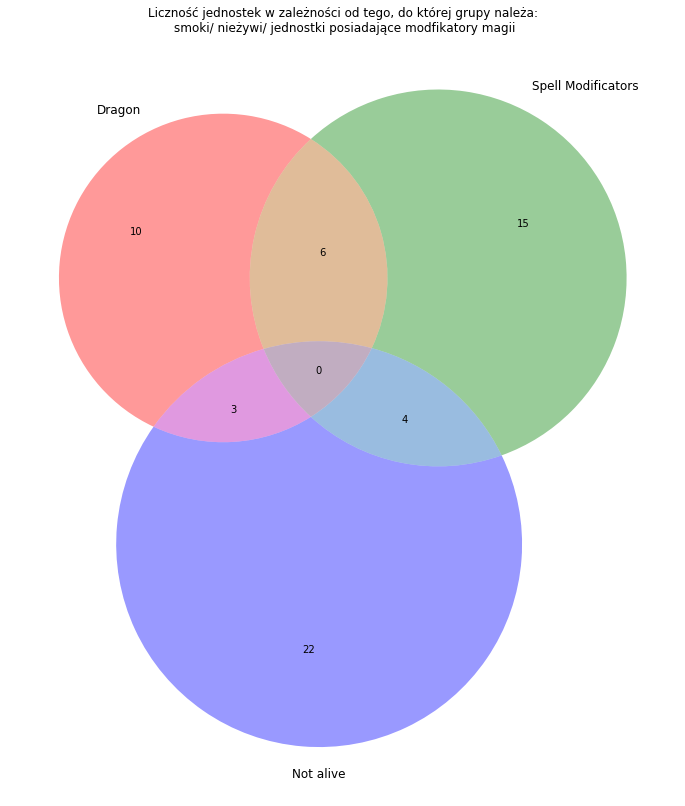

In [75]:
#Część całości #6 - Diagram Venna - przydatny do pokazywania logicznego iloczynu między kilkoma zbiorami
#Wykres przedstawia liczności 3 parametrów jednostki i ich koniunkcji
#Jedyny sensowny wykres pozwalający pokazać relacje między zbiorami, które nie są rozłączne

df2=df.copy()
a=[0]*3
gr=3

a[0]=df2['Unit_name'].str.contains('Dragon$')
a[1]=df2['Special_abilities'].str.contains('[sS]pell')
a[2]=df2['Special_abilities'].str.contains('Un(living|dead)', regex=True)

z=pow(2,gr)
aef=[0]*z
#Wykładniczy generator iloczynów logicznych jakichś zbiorów - biorę liczbę, i z jej reprezentcji binarnej biorę złożenie zbiorów
#np. 6 oznacza 110 - biorę iloczyn 1,2 zbioru, zostawiam 0. zbiór. Albo 5 - 101 - 0. i 2. zbiór łączę, zostawiam 1.
#Na takiej zasadzie działa venn - usuwam jedynie 1. element (przesztrzeń omega, P(omega)=1 - cała rzeczywistość)
for i in range(z):
    f=[True]*df2.shape[0]
    j=i
    ij=0
    
    while (j>0):
        if (j%2==1):
            f=f&a[ij]
        ij+=1
        j=j//2
        
    aef[i]=sum(f)
fig, ax=plt.subplots(1,1, figsize=(14,14))
venn3(aef[1:z], set_labels=['Dragon','Spell Modificators', 'Not alive'], ax=ax)
ax.set_title('Liczność jednostek w zależności od tego, do której grupy należa:\n smoki/ nieżywi/ jednostki posiadające modfikatory magii')
plt.show()

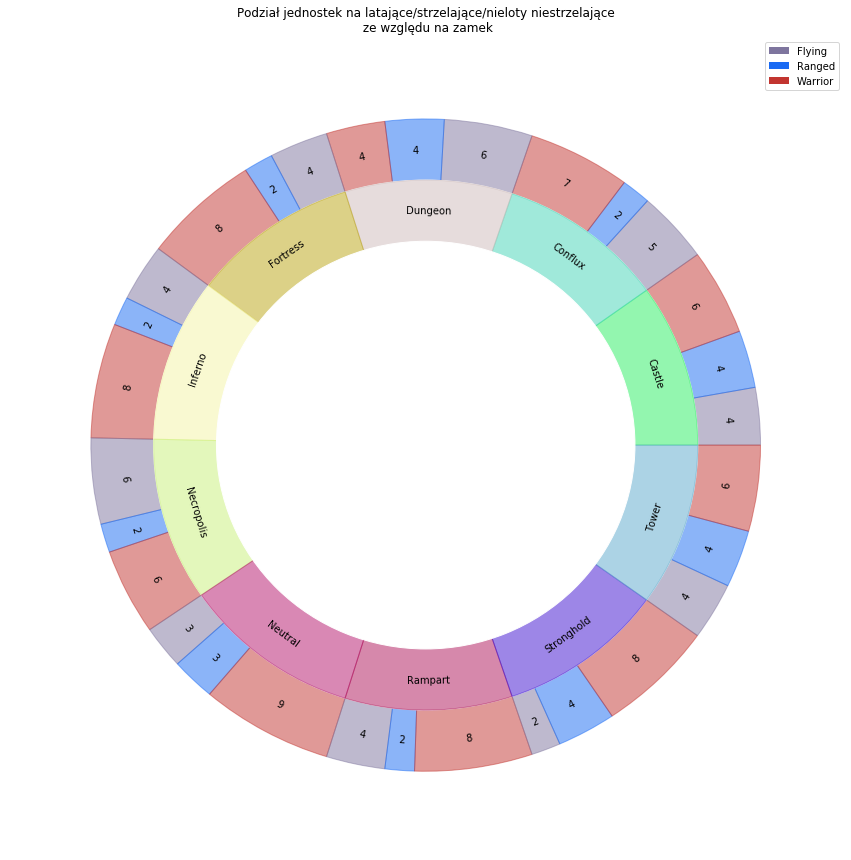

In [76]:
#Część całości #7 - sunburst - pozwala robić rzeczy, które są niemożliwe w zwykłym piecharcie/donucie - zhierarchizowanie obserwacji
#Preferowany na ogół jest dendrogram - kartezjański, nie polarny, ale brzydszy, mi się wydaje mniej informatywny
#Wykres przedstawia podział jednostek ze względu na zamek
#Jak ktoś chce mindfucka, może dodać do cols nowe kolumny, ewentualnie pozmieniać xlim i ylim

#ax - oś, df - dataframe, cols - kolumny od najbardziej wewnętrznej do najbardziej zewnętrznej, leg - legenda
def sunnburst(ax, df, cols, leg=[]):
    df['All']=1
    t1=0
    Cl=len(cols)
    summ=df.shape[0]
    
    #Stworzenie nowego dataframe'a, który przechowuje kolory dla Wedge'ów
    colz=['Column', 'Value', 'Color', 'Used']    
    allez=[] 
    for j in range(Cl):
        tp=np.unique(df[cols[j]])
        for i in range(0, len(tp),1):
            c1, c1=gen_rand_colors(0)
            allez.append([cols[j], tp[i], c1, 0])
    dfendet=pd.DataFrame.from_records(allez, columns=colz)
    
    #Pętla po wszystkich kolumnach, które hierarchizuję
    for j in range(0, Cl, 1):
        #Grupowanie, znalezienie indeksów: W - ostatnia kolumna(do labela), Z-liczność
        df3=df.groupby(cols[0:Cl-j], as_index=False).sum()
        Z=df3.columns.get_loc('All')
        W=df3.columns.get_loc(cols[Cl-j-1])
        t1=0
        #Iteracja po wszystkich obserwacjach w podzbiorze dataframe'a
        for i in range(0, df3.shape[0], 1):
            secsum=df3.iat[i,Z]
            view=dfendet[(dfendet['Column']==cols[Cl-j-1])&(dfendet['Value']==df3.iat[i,W])]
            colval=view.iat[0,2]
            
            #Dodanie Wedge'a (nie mam pojęcia, jak to przetłumaczyć), zmiana kąta t1 - nowy początek półokręgu w stopniach, dg i rad potrzebne do wyświetlania tekstu
            f=patch.Wedge(center=(0,0), r=1+(Cl-j)*0.3, theta1=t1, theta2=t1+(secsum/summ)*360, color=colval, alpha=0.5)
            dg=(2*t1+(secsum/summ)*360)/2
            rad=1+(Cl-j)*0.3-0.15
            t1=t1+(secsum/summ)*360
            ax.add_artist(f)
            
            #Kąt do wyświetlania tekstu
            sdg=90+dg
            if (sdg>90 and sdg<270):
                sdg-=180
            
            #Najbardziej wewnętrzny krąg - pokazać tekst. Co istotne, sin i cos działają w radianach - stąd konwersja
            if (j==Cl-1):
                ax.text(x=rad*math.cos(dg*math.pi/180), y=rad*math.sin(dg*math.pi/180), s=df3.iat[i,W], rotation=sdg, verticalalignment='center', horizontalalignment='center')
            #Zewnętrzne kręgi - dodać do legendy(jeśli jeszcze nie dodany), dodać tekst - ilość danych obserwacji
            else:
                if (view.iat[0,3]==0):
                    leg.append(Patch(facecolor=colval, label=view.iat[0,1]))
                    dfendet.loc[(dfendet['Column']==cols[Cl-j-1])&(dfendet['Value']==df3.iat[i,W]),'Used']=1
                ax.text(x=rad*math.cos(dg*math.pi/180), y=rad*math.sin(dg*math.pi/180), s=df3.iat[i,Z], rotation=sdg, verticalalignment='center', horizontalalignment='center') 
                
            
            
        f=patch.Wedge(center=(0,0), r=1+(Cl-j-1)*0.3, theta1=0, theta2=360, color='white', alpha=1)
        ax.add_artist(f)
    ax.axis('off')
    return

df2=df.copy()
fig, ax=plt.subplots(1,1,figsize=(15,15))
lg=[]
sunnburst(ax=ax, df=df2, cols=['Castle', 'Type'], leg=lg)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_title('Podział jednostek na latające/strzelające/nieloty niestrzelające\n ze względu na zamek')
ax.legend(handles=lg)
plt.show()